# Introduction

The purpose of this homework is to solve a classification problem proposed as a competition in the Kaggle InClass platform, where each team of two members will try to get the maximum score. You can apply any of the concepts and techniques studied in class for exploratory data analysis, feature selection and classification.

All the details about the classification problem can be found [in kaggle](https://www.kaggle.com/c/anomaly-detection-in-4g-cellular-networks/)

# Pre-Processing

In [ ]:
import numpy as np
import pandas as pd
import os
import math

import sklearn.tree
import sklearn.ensemble

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA

## The Dataset

The dataset has been obtained from a real LTE deployment. During two weeks, different metrics were gathered from a set of 10 base stations, each having a different number of cells, every 15 minutes. The dataset is provided in the form of a csv file, where each row corresponds to a sample obtained from one particular cell at a certain time. Each data example contains the following features:

* `Time` : hour of the day (in the format hh:mm) when the sample was generated.
* `CellName`: text string used to uniquely identify the cell that generated the current sample. CellName is in the form xαLTE, where x identifies the base station, and α the cell within that base station (see the example in the right figure).
* `PRBUsageUL` and `PRBUsageDL`: level of resource utilization in that cell measured as the portion of Physical Radio Blocks (PRB) that were in use (%) in the previous 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
* `meanThrDL` and `meanThrUL`: average carried traffic (in Mbps) during the past 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
* `maxThrDL` and `maxThrUL`: maximum carried traffic (in Mbps) measured in the last 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
* `meanUEDL` and `meanUEUL`: average number of user equipment (UE) devices that were simultaneously active during the last 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
* `maxUEDL` and `maxUEUL`: maximum number of user equipment (UE) devices that were simultaneously active during the last 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
`maxUE_UL+DL`: maximum number of user equipment (UE) devices that were active simultaneously in the last 15 minutes, regardless of UL and DL.

* `Unusual`: labels for supervised learning. A value of 0 determines that the sample corresponds to normal operation, a value of 1 identifies unusual behavior.

In [ ]:
# Clone repository in order to get access locally to the datasets
!rm -rf .git README.md
!git clone https://github.com/sergio-gimenez/anomaly-4G-detection 

In [ ]:
train = pd.read_csv('anomaly-4G-detection/ML-MATT-CompetitionQT2021_train.csv', sep=';')
test = pd.read_csv('anomaly-4G-detection/ML-MATT-CompetitionQT2021_test.xls', sep=';' )

In [ ]:
# Separate labels from data 
X = train.drop('Unusual', axis='columns')
y = train['Unusual']

# We split the data into training and validation subsets (80% and 20%) in
# order to validate our training
X_train, X_validation, y_train, y_validation = train_test_split(X, y, 
                                                                train_size=0.8,
                                                                random_state=1, stratify = y)
X_test = test

## Using non-quantitative features

First thing to do regarding data pre-processing is to make sure all features are ready to be used, specially the non numerical ones: `Time` and `CellName`. `Time` has relevant correlation with the maximum traffic hours, although the day is not included in the date, still is a relevant enough feature. In order to make `Time` ready to use, there are several approaches. However, the chosen one has been to convert the time (minutes) to radians and split them up into two features, one applying a cosine and the other with sine. Regarding `CellName`, a simple mapping 1:1 with a numerical identifier for each cell name has been carried out.

In [ ]:
#Refactor time feature to minuts and cellName to unique identifier 1:1
def getTimeInMinutes(x):
  hh, mm  = x.split(":")
  return int(hh)* 60 + int(mm)

def createCellNameDictionary(data):
  cellList = []
  for i in data["CellName"]:
    cellList.append(i)
  cellList = set(cellList)
  cellDict = {}
  for idx, value in enumerate(cellList):
    cellDict[value]=idx
  return cellDict

def refactorFeaturesDataframe(data):
  #data["Time"] = data["Time"].apply(lambda x: getTimeInMinutes(x))
  data["TimeCos"] = data["Time"].apply(lambda x: math.cos(getTimeInMinutes(x)*math.pi/(12*60)))
  data["TimeSin"] = data["Time"].apply(lambda x: math.sin(getTimeInMinutes(x)*math.pi/(12*60)))
  del data["Time"]

  cellNameDict = createCellNameDictionary(data);
  data["CellName"] = data["CellName"].apply(lambda x: cellNameDict[x])
  return data

In [ ]:
#Refactoring data from features to useful values
X_train_df = refactorFeaturesDataframe(X_train)
X_train = X_train_df.to_numpy()
y_train = y_train.to_numpy()
X_validation = refactorFeaturesDataframe(X_validation).to_numpy()
y_validation = y_validation.to_numpy()
X_test = refactorFeaturesDataframe(test).to_numpy()

## Data Visualisation

#### PCA

Regarding PCA, given the number of new features desired, it tries to provide the projection using the correlation between some dimensions and keeping the maximum amount of information about the original data distribution. As can be seen in the image below, there are not clear clusters nor a clear defined pattern. Usual and unusual samples are mixed in many ways, fact that constraints the classifier that is going to be used, e.g linear classifiers can be directly excluded.

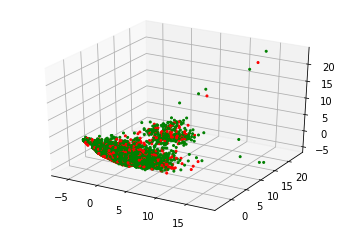

In [ ]:
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_train)
X_reduce = pca.fit_transform(X_norm)

colors=['green' if l==0 else 'red' for l in y_train]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_reduce[:,0], X_reduce[:, 1], X_reduce[:, 2], s=4, alpha=1,color=colors)
plt.show()

#### t-SNE

In order to go through  a different approach, a non-linear reduction such as t-SNE has been tried out. t-SNE is an unsupervised method that minimizes the divergence between a distribution that measures pairwise similarities of the input and a distribution that measures the similarities of the corresponding low-dimensional points in the embedding. As it can be observed in the figure below, t-SNE has built a set of separable clusters but with samples of different classes mixed in the same clusters, without a clear visual pattern. 

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 29523 samples in 0.064s...
[t-SNE] Computed neighbors for 29523 samples in 5.065s...
[t-SNE] Computed conditional probabilities for sample 1000 / 29523
[t-SNE] Computed conditional probabilities for sample 2000 / 29523
[t-SNE] Computed conditional probabilities for sample 3000 / 29523
[t-SNE] Computed conditional probabilities for sample 4000 / 29523
[t-SNE] Computed conditional probabilities for sample 5000 / 29523
[t-SNE] Computed conditional probabilities for sample 6000 / 29523
[t-SNE] Computed conditional probabilities for sample 7000 / 29523
[t-SNE] Computed conditional probabilities for sample 8000 / 29523
[t-SNE] Computed conditional probabilities for sample 9000 / 29523
[t-SNE] Computed conditional probabilities for sample 10000 / 29523
[t-SNE] Computed conditional probabilities for sample 11000 / 29523
[t-SNE] Computed conditional probabilities for sample 12000 / 29523
[t-SNE] Computed conditional probabilities for sa

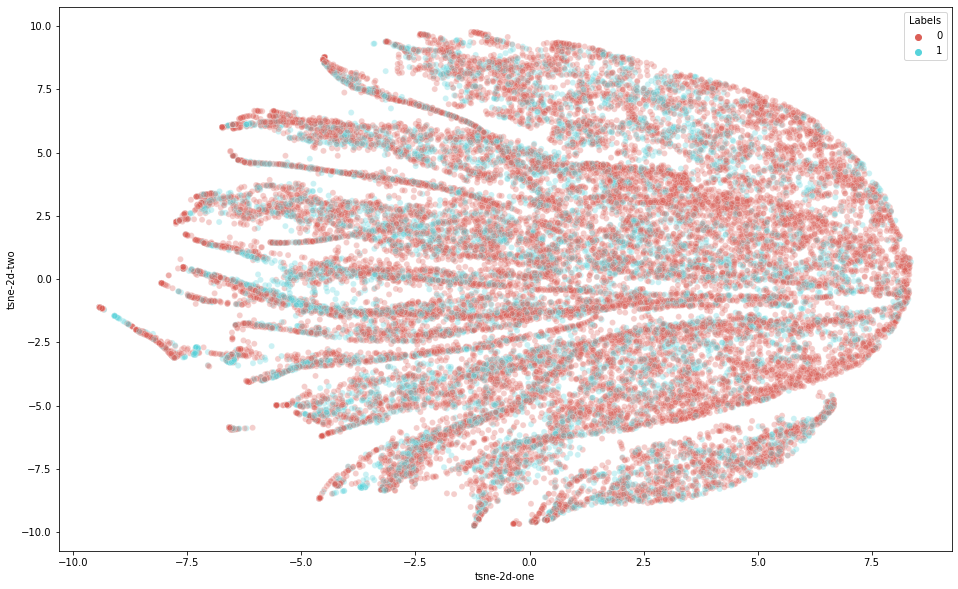

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_train)

df_subset={}
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['Labels'] = y_train

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Labels",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3
)

#### Matrix Correlation

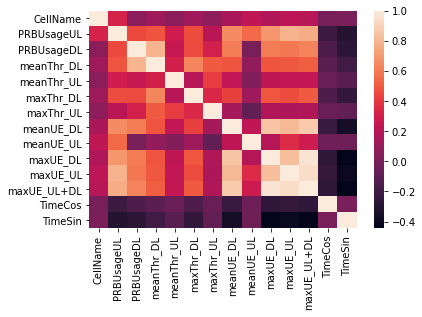

In [ ]:
corrMatrix = X_train_df.corr()
sns.heatmap(corrMatrix, annot=False)
plt.show()

# Solving the Classification Problem

### XGBoost. Training the classifier

One of the widely ensembled methods are gradient boosted decision trees. In a summarized way, boosting takes an iterative approach for training models. It trains models in succession, with each new model being trained to correct the errors made by the previous ones. A widely used implementation of the training described before is `XGBoost`. `XGBoost` is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.  
All the necessary information about `XGBoost` can be found in the [XGBoost Documentation Page](https://xgboost.readthedocs.io/en/latest/)

---
**Note:**

If you want to avoid the training process, and use the pre trained model, make sure the `xgb_model.joblib` is loaded in `anomaly-4G-detection/xgb_model.joblib`. 

If you want to go through the training process there are two ways:
* Fast way: The most suitable parameters we have found are already hardcoded in the pipe and no training process is involved at all in this part.

* Whole training process: If you want to do the whole training process by yourself comment the parameters in the pipe, comment 

    ```
    clf_GS = RandomizedSearchCV(estimator=pipe, param_distributions=parameters, n_jobs=10, verbose=1, cv=[(slice(None), slice(None))], n_iter= 1)
    ```

  and uncomment

  ```
  clf_GS = RandomizedSearchCV(estimator=pipe, param_distributions=parameters, n_jobs=10, verbose=1, cv=5, n_iter= 500)  
  ```

In [ ]:
from xgboost import XGBClassifier, plot_importance
from joblib import dump, load
from google.colab import files
from scipy.stats import uniform, randint

try:
  clf_GS = load('anomaly-4G-detection/xgb_model.joblib') 
  training = False
  
except:
  training = True
  pipe = Pipeline(steps=[('std_slc', StandardScaler()),
                         ('xgb_clf', XGBClassifier(random_state=1,
                                                      scale_pos_weight=7,
                                                      colsample_bytree= 0.053381469489678104,
                                                      eta= 0.20289460663803338,
                                                      gamma= 0.88723107873764,
                                                      learning_rate= 0.15455380920536027,
                                                      max_depth= 26,
                                                      min_child_weight= 1,
                                                      n_estimators= 565,
                                                      subsample= 0.9738168894035317))])
  
  parameters = {
  # 'xgb_clf__eta'    : uniform(0.2, 0.35),
  # "xgb_clf__colsample_bytree": uniform(0.05, 0.2),
  # "xgb_clf__min_child_weight": randint(1, 5),
  # "xgb_clf__gamma": uniform(0.35, 0.6),
  # "xgb_clf__learning_rate": uniform(0.1, 0.3), # default 0.1 
  # "xgb_clf__max_depth": randint(10, 30), # default 3
  # "xgb_clf__n_estimators": randint(500, 1000), # default 100
  # "xgb_clf__subsample": uniform(0.6, 0.99)
  }

  #clf_GS = RandomizedSearchCV(estimator=pipe, param_distributions=parameters, n_jobs=10, verbose=1, cv=5, n_iter= 500)  
  clf_GS = RandomizedSearchCV(estimator=pipe, param_distributions=parameters, n_jobs=10, verbose=1, cv=[(slice(None), slice(None))], n_iter= 1)
  clf_GS.fit(X_train, y_train)    

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   17.2s finished


### Select features from model

The last experiment that leads to a considerable enhancement is to take advantage of the features selected by the model to perform a feature reduction. Take into account that `XGBoost`, in essence, is a set of ensemble decision trees, so we could evaluate its features importance once the model is trained. 

Evaluating that data, we get the optimized threshold to reduce the accuracy using just 3 features (check next code block). The 'SelectFromModel' module allowed us to pass the thresholds to the already trained model and, once the best threshold is validated, transform the datasets using just the features that pass the threshold. This final experiment let us reduce the recall from 44 errors in validation to 14. In the test set we achieved a score of 99.83\%, which was our best performance in the challenge.

In [ ]:
from sklearn.feature_selection import SelectFromModel

if training:

  treshold_train_error = []
  treshold_val_error = []
  thresholds = np.sort(clf_GS.best_estimator_.named_steps["xgb_clf"].feature_importances_)
  
  current_error = 100.0
  best_th = 0

  for thresh in thresholds:

    # Do a feature reduction with relevant feature
    new_X_train = X_train
    selection = SelectFromModel(clf_GS.best_estimator_.named_steps["xgb_clf"], threshold=thresh, prefit=True)
    select_X_train = selection.transform(new_X_train)
      
    # Fit the classifier with the reduced dataset
    selection_model = RandomizedSearchCV(estimator=pipe, param_distributions=parameters, n_jobs=10, verbose=1, cv=[(slice(None), slice(None))], n_iter= 1)
    selection_model.fit(select_X_train, y_train)
    
    # Evaluate predictions with the dataset trained with the feature reduction
    pred_train = selection_model.predict(select_X_train)
    select_X_val = selection.transform(X_validation)
    pred_val = selection_model.predict(select_X_val)
    

    """"                       
         Classification report
         ---------------------
    """
    train_error = 1. - accuracy_score(y_train, pred_train)    
    train_cmat = confusion_matrix(y_train, pred_train)
    val_error = 1. - accuracy_score(y_validation, pred_val)
    val_cmat = confusion_matrix(y_validation, pred_val)

    treshold_train_error.append(train_error)
    treshold_val_error.append(val_error)

    print("\nThreshold of value %f" % thresh)
    print("--------------------------------")
    print('\ntrain error: %f ' % train_error)
    print('train confusion matrix:')
    print(train_cmat)
    print('\ntest error: %f ' % val_error)
    print('test confusion matrix:')
    print(val_cmat)
    print("\n")

    if val_error < current_error:
      current_error = val_error
      best_th = thresh
      best_transformation = select_X_train

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   15.0s finished



Threshold of value 0.005162
--------------------------------

train error: 0.000000 
train confusion matrix:
[[21377     0]
 [    0  8146]]

test error: 0.003929 
test confusion matrix:
[[5340    4]
 [  25 2012]]


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   14.4s finished



Threshold of value 0.005408
--------------------------------

train error: 0.000000 
train confusion matrix:
[[21377     0]
 [    0  8146]]

test error: 0.003794 
test confusion matrix:
[[5339    5]
 [  23 2014]]


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   13.3s finished



Threshold of value 0.010272
--------------------------------

train error: 0.000000 
train confusion matrix:
[[21377     0]
 [    0  8146]]

test error: 0.002981 
test confusion matrix:
[[5340    4]
 [  18 2019]]


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   12.4s finished



Threshold of value 0.010853
--------------------------------

train error: 0.000034 
train confusion matrix:
[[21376     1]
 [    0  8146]]

test error: 0.002981 
test confusion matrix:
[[5340    4]
 [  18 2019]]


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   12.4s finished



Threshold of value 0.010869
--------------------------------

train error: 0.000034 
train confusion matrix:
[[21376     1]
 [    0  8146]]

test error: 0.002845 
test confusion matrix:
[[5340    4]
 [  17 2020]]


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   12.3s finished



Threshold of value 0.013124
--------------------------------

train error: 0.000034 
train confusion matrix:
[[21376     1]
 [    0  8146]]

test error: 0.002439 
test confusion matrix:
[[5340    4]
 [  14 2023]]


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   12.4s finished



Threshold of value 0.036166
--------------------------------

train error: 0.000034 
train confusion matrix:
[[21376     1]
 [    0  8146]]

test error: 0.002981 
test confusion matrix:
[[5338    6]
 [  16 2021]]


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   13.4s finished



Threshold of value 0.044093
--------------------------------

train error: 0.000068 
train confusion matrix:
[[21375     2]
 [    0  8146]]

test error: 0.003387 
test confusion matrix:
[[5339    5]
 [  20 2017]]


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   14.7s finished



Threshold of value 0.048566
--------------------------------

train error: 0.000034 
train confusion matrix:
[[21376     1]
 [    0  8146]]

test error: 0.003252 
test confusion matrix:
[[5338    6]
 [  18 2019]]


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   13.2s finished



Threshold of value 0.057551
--------------------------------

train error: 0.000102 
train confusion matrix:
[[21374     3]
 [    0  8146]]

test error: 0.002574 
test confusion matrix:
[[5338    6]
 [  13 2024]]


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   12.9s finished



Threshold of value 0.072275
--------------------------------

train error: 0.000068 
train confusion matrix:
[[21375     2]
 [    0  8146]]

test error: 0.002439 
test confusion matrix:
[[5340    4]
 [  14 2023]]


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   12.2s finished



Threshold of value 0.097169
--------------------------------

train error: 0.000000 
train confusion matrix:
[[21377     0]
 [    0  8146]]

test error: 0.002439 
test confusion matrix:
[[5340    4]
 [  14 2023]]


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   10.6s finished



Threshold of value 0.125850
--------------------------------

train error: 0.012228 
train confusion matrix:
[[21365    12]
 [  349  7797]]

test error: 0.015987 
test confusion matrix:
[[5336    8]
 [ 110 1927]]


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   12.7s finished



Threshold of value 0.462643
--------------------------------

train error: 0.017647 
train confusion matrix:
[[21201   176]
 [  345  7801]]

test error: 0.020051 
test confusion matrix:
[[5303   41]
 [ 107 1930]]




Train and predict the data with the best feature reduction

In [ ]:
  from sklearn.feature_selection import SelectFromModel

  # Get the best estimator we found in the previous block
  new_X_train = X_train
  selection = SelectFromModel(clf_GS.best_estimator_.named_steps["xgb_clf"], threshold=best_th , prefit=True)
  select_X_train = selection.transform(new_X_train)

  # Train the classifier with the best feature reduction
  selection_model = RandomizedSearchCV(estimator=pipe, param_distributions=parameters, n_jobs=10, verbose=1, cv=[(slice(None), slice(None))], n_iter= 1)
  selection_model.fit(select_X_train, y_train)

  # Save the model in a file and download locally.
  dump(clf_GS, 'xgb_model.joblib')
  files.download('xgb_model.joblib')

  pred_train = selection_model.predict(select_X_train)
  select_X_val = selection.transform(X_validation)
  pred_val = selection_model.predict(select_X_val)

  train_error = 1. - accuracy_score(y_train, pred_train)
  train_cmat = confusion_matrix(y_train, pred_train)
  val_error = 1. - accuracy_score(y_validation, pred_val)
  val_cmat = confusion_matrix(y_validation, pred_val)

  
  """"                       
         Classification report
         ---------------------
  """

  print("\nThreshold of value %f" % thresh)
  print("--------------------------------")
  print('\ntrain error: %f ' % train_error)
  print('train confusion matrix:')
  print(train_cmat)
  print('\ntest error: %f ' % val_error)
  print('test confusion matrix:')
  print(val_cmat)
  print("\n")

  print("TRAINING\n" + classification_report(y_train, pred_train))
  print("\nTESTING\n" + classification_report(y_validation, pred_val))

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   11.9s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Threshold of value 0.462643
--------------------------------

train error: 0.000034 
train confusion matrix:
[[21376     1]
 [    0  8146]]

test error: 0.002439 
test confusion matrix:
[[5340    4]
 [  14 2023]]


TRAINING
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21377
           1       1.00      1.00      1.00      8146

    accuracy                           1.00     29523
   macro avg       1.00      1.00      1.00     29523
weighted avg       1.00      1.00      1.00     29523


TESTING
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5344
           1       1.00      0.99      1.00      2037

    accuracy                           1.00      7381
   macro avg       1.00      1.00      1.00      7381
weighted avg       1.00      1.00      1.00      7381



#### Insightful data visualization

##### Evolution of the error for different thresholds

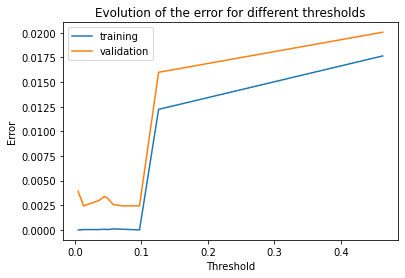

In [ ]:
  fig, ax = plt.subplots()
  ax.plot(thresholds, treshold_train_error, label='training')
  ax.plot(thresholds, treshold_val_error, label='validation')
  ax.set(xlabel='Threshold', ylabel='Error')
  ax.legend()
  plt.title('Evolution of the error for different thresholds')
  plt.show()

##### Best performance feature reduction

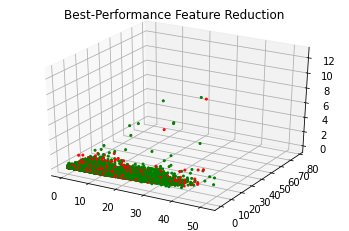

In [ ]:
  colors=['green' if l==0 else 'red' for l in y_train]
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(best_transformation[:,0], best_transformation[:, 1], best_transformation[:, 2], s=4, alpha=1,color=colors)

  plt.title('Best-Performance Feature Reduction')
  plt.show()

##### Feature importance

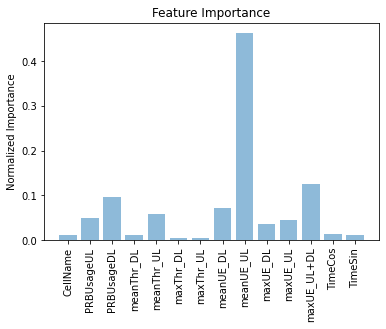

In [ ]:
  feature_importances = clf_GS.best_estimator_.named_steps["xgb_clf"].feature_importances_
  columns = X_train_df.columns
  
  fig = plt.figure() 
  plt.bar(np.arange(14) , feature_importances, align='center', alpha=0.5)
  plt.xticks(np.arange(14), columns, rotation='vertical')
  plt.ylabel('Normalized Importance')
  plt.title('Feature Importance')
  plt.show()

In [ ]:
  select_X_test = selection.transform(X_test)
  pred_test = selection_model.predict(select_X_test)

In [ ]:
if training == False:

  pred_train = clf_GS.predict(X_train)
  pred_val = clf_GS.predict(X_validation)

  print("TRAINING\n" + classification_report(y_train, pred_train))
  print("\nTESTING\n" + classification_report(y_validation, pred_val))

  train_error = 1. - accuracy_score(y_train, pred_train)
  train_cmat = confusion_matrix(y_train, pred_train)
  val_error = 1. - accuracy_score(y_validation, pred_val)
  val_cmat = confusion_matrix(y_validation, pred_val)

  print('train error: %f ' % train_error)
  print('train confusion matrix:')
  print(train_cmat)
  print('test error: %f ' % val_error)
  print('test confusion matrix:')
  print(val_cmat)

# Submission Formatting

In [ ]:
%%shell
# Create submission file if it does not exists
file=predictions.csv
if [ ! -e "$file" ] ; then
    touch anomaly-4G-detection/"$file"
fi

In [ ]:
# Create index column in data frame object
submission_dataframe = pd.DataFrame(np.arange(1, 9159), columns=['Id']) 

# Append predictions of test data as column
submission_dataframe['Label'] = pred_test

# Convert Data Frame object to CSV
submission_dataframe.to_csv('predictions.csv', index=False)

!mv predictions.csv anomaly-4G-detection/
predictions = pd.read_csv('anomaly-4G-detection/predictions.csv')
predictions

,Id,Label
0,1,1
1,2,0
2,3,0
3,4,0
4,5,1
...,...,...
9153,9154,0
9154,9155,1
9155,9156,0
9156,9157,0


In [ ]:
#!rm anomaly-4G-detection/predictions.csv